# 第2章 量子アルゴリズム入門 

前章では、量子ビットの表し方と量子ゲートについて学んだ。この章では、量子ゲートを組み合わせ、簡単な量子アルゴリズムを実行してみよう。例として取り挙げるのは、ユニタリ行列の固有値の位相を求めるアダマールテストと位相推定、および位相推定に必要となる量子フーリエ変換というアルゴリズムである。特に位相推定アルゴリズムは、数多くの量子アルゴリズムのサブルーチンとして使われており、量子アルゴリズムの中でも最も重要なものの一つとなっている。

In [1]:
from sympy import *
from sympy.physics.quantum import *
from sympy.physics.quantum.qubit import Qubit,QubitBra
init_printing() # ベクトルや行列を綺麗に表示するため
from sympy.physics.quantum.gate import X,Y,Z,H,S,T,CNOT,SWAP,CPHASE,CGateS

In [2]:
# Google Colaboratory上でのみ実行してください
from IPython.display import HTML
def setup_mathjax():
    display(HTML('''
    <script>
        if (!window.MathJax) {
            window.MathJax = {
                'tex2jax': {
                    'inlineMath': [['$', '$'], ['\\(', '\\)']],
                    'displayMath': [['$$', '$$'], ['\\[', '\\]']],
                    'processEscapes': true,
                    'processEnvironments': true,
                    'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
                    'displayAlign': 'center',
                },
                'HTML-CSS': {
                    'styles': {'.MathJax_Display': {'margin': 0}},
                    'linebreaks': {'automatic': true},
                    // Disable to prevent OTF font loading, which aren't part of our
                    // distribution.
                    'imageFont': null,
                },
               'messageStyle': 'none'
            };
            var script = document.createElement("script");
            script.src = "https://colab.research.google.com/static/mathjax/MathJax.js?config=TeX-AMS_HTML-full,Safe";
            document.head.appendChild(script);
        }
    </script>
    '''))
get_ipython().events.register('pre_run_cell', setup_mathjax)

### アダマールテストで位相の情報を取り出す

アダマールテストでは、ユニタリ演算$U$の固有値$e^{i\lambda}$の位相$\lambda$によって測定の確率分布が決まるため、測定値のサンプルから$\lambda$を推定できることが分かった。これをもう少し工夫することで、測定結果から位相の情報をより直接的に取り出すことができることを見ていこう。

下準備として、$\lambda/2\pi$を2進展開しよう：
$$
\frac{\lambda}{2\pi} = \frac{j_1}{2^1} \frac{j_2}{2^2} \cdots \frac{j_k}{2^k} \cdots
$$
$j_k$は0または1の値を取る（古典）ビットである。$\lambda$は$e^{i\lambda}$の形でのみ出てくるので、$0 \leq \lambda < 2\pi$として一般性を失わない。この2進展開を、通常の小数の表記にならって以下のように書く。
$$
\lambda = (2\pi) 0.j_1 j_2 \ldots j_k \ldots
$$
以下では簡単のため、$\lambda/2\pi$は小数点以下$r$桁で書けるものとする。
$$
\lambda = (2\pi) 0.j_1 j_2 \ldots j_r
$$

さて、アダマールテストでは制御ユニタリ演算として$\Lambda(U)$を用いたが、ここではそれを少し変えて$\Lambda(U^{2^k})$としてみよう。前節の前半と同様、$|\psi\rangle$が$U$の固有状態であることを仮定する。制御ユニタリ演算を行なった後の状態は
$$
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{i2^k\lambda} |1\rangle
\right)
\otimes |\psi\rangle
$$
上記の2進展開を使うと、
$$
2^k \lambda =
2^k \cdot (2\pi)0.j_1 j_2 \ldots j_r =
(2\pi)j_1 j_2 \ldots j_k . j_{k+1} \ldots j_r
$$
$e^{i(2\pi)j_1 \ldots j_k} = 1$を用いて、１つ目の量子ビットの状態を計算すると、
$$
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{i(2\pi)0.j_{k+1} \ldots j_r} |1\rangle
\right)
$$
まず$k = r-1$の場合を考えると、
$$
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{i(2\pi)0.j_r} |1\rangle
\right) =
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{ij_r\pi}|1\rangle
\right)
$$
これにアダマール演算を行うと、
$$
H\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{ij_r\pi}|1\rangle
\right) =
|j_r\rangle
$$
となり、小数点以下$r$桁目のビットがそのまま１つ目の量子ビットの状態になっていることが分かる（$e^{i0}=1, e^{i\pi}=-1$に注意）。次に$k = r - 2$の場合を考えると、制御ユニタリ演算後の状態は
$$
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{i(2\pi)0.j_{r-1} j_r} |1\rangle
\right) =
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 (e^{i\pi/2})^{j_r} e^{i(2\pi)0.j_{r-1}} |1\rangle
\right)
$$
$j_r$の値が分かっていると仮定すると、$j_r=1$の場合のみ、$|1\rangle$の相対位相を$-\pi/2$回す演算を行えばよい。$|1\rangle$の相対位相を$-2\pi/2^k$回す演算を
$$
R_k \equiv
\left(
\begin{array}{cc}
1 & 0\\
0 & e^{-i(2\pi)/2^k}
\end{array}
\right)
$$
とすると、
$$
R_2
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 (e^{i\pi/2})^{j_r} e^{i(2\pi)0.j_{r-1}} |1\rangle
\right) =
\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{i(2\pi)0.j_{r-1}} |1\rangle
\right)
$$
あとは$k = r - 1$の場合と同様にアダマール演算を行うと
$$
H\frac{1}{\sqrt{2}}
\left(
 |0\rangle +
 e^{ij_{r-1}\pi}|1\rangle
\right) =
|j_{r-1}\rangle
$$
となり、小数点以下$r-1$桁目のビットを量子ビットの状態として取り出すことができる。

このように、アダマールテストを少し変形することで、固有値の位相を1桁ずつ量子ビットの状態として取り出すことができる。この手続きを量子回路で行うのが、以下で説明する位相推定アルゴリズムである。

上記の計算で、$r$桁目については通常のアダマールテストと同様アダマール演算を用いたが、$r-1$桁目については、$r$桁目の情報に基づいて適応的に$R_2$演算を行なったことに注意しよう。この適応的な演算は、量子回路においては制御ユニタリ演算に対応する。

### 位相推定アルゴリズム

最後に、量子コンピュータにとってもっとも重要なアルゴリズムである位相推定アルゴリズムを紹介する。上記のアダマールテストをより精度が良くなるように、測定側の量子ビットを拡張したのが、Kitaevによって提案された位相推定アルゴリズムである。詳細はともかく、どのような操作ができるアルゴリズムなのかを、まず紹介しよう。  
　$U$を量子回路として構成できる一般的なユニタリ行列とする。$U$の固有ベクトルを$|{\rm eigen} _i \rangle$とし、対応する固有値を$\lambda _i$とする。ある一般的な量子状態$|\psi\rangle$が与えられたとする。これは必ず固有ベクトルで展開できる：
$$
|\psi \rangle = \sum _i c_i |{\rm eigen}_i \rangle
$$
もちろん具体的に$c_i$がどのような値になるかはわからなくてよい。このとき位相推定アルゴリズムは、$r$個の補助量子ビットを用いて、入力状態
$$
|00...0\rangle | \psi \rangle
$$
を、
$$
\sum _i c_i |\lambda_i \rangle | {\rm eigen_i} \rangle 
$$
へと変換するアルゴリズムのことである。つまり、重ね合わせの中にあるそれぞれの固有ベクトルに対応した固有値を$r$個の補助量子ビットへと取り出すアルゴリズムになっている。この状態に対して測定をすると、確率 
$$
p_i = |c_i |^2
$$
で、どれか一つの固有ベクトルとその固有値が乱択される。このアルゴリズムは、素因数分解や分子などのエネルギー計算のための量子化学アルゴリズム、そしてその他多くのアルゴリズムのサブルーチンとして利用されていおり、量子コンピュータが従来コンピュータよりも指数的に高速に特定の問題において解を得られる（と期待されている）最も重要な例である。

以下では、入力状態を固有状態$|{\rm eigen}\rangle$とその固有値$\lambda$に限定して、位相推定アルゴリズムを説明していくことにする（入力状態が固有状態の重ね合わせの場合でも全く同じ議論が使えるので、一般性は失われていない）。 アダマールテストでは1つしか測定用の量子ビットを使わなかったが、位相推定では、測定用の補助量子ビットとして$r$個の量子ビットを確保する。
位相推定を行う回路は以下の図2のようである。
![図2](https://github.com/qulacs/quantum-native-dojo/raw/master/notebooks/figs/PEA.png)

まず、$|0\rangle$に初期化された$r$個の量子ビットを用いて、アダマールテストと同様に制御ユニタリー演算を作用させる。
ただし前節で行ったように、$k$番目（$k=1,...,r$）の補助量子ビットは制御$U^{2^{k-1}}$演算
をすることにする。
前節と同様、ユニタリー演算$U$の固有値の位相$\lambda$を$r$ビットの２進小数を用いて
\begin{eqnarray}
\lambda = (2\pi) 0.j_1 j_2...j_r
\end{eqnarray}
と書いておく。
$k$番目のプローブ量子ビットには$e^{i \lambda 2^k}$
の位相が獲得される（位相キックバック）ので、
制御ユニタリー演算子を全て作用させると、前節で計算したように
\begin{eqnarray}
\bigotimes _{k=1}^{r} \frac{|0\rangle + e^{i (2\pi)0.j_k...j_r} |1\rangle }{\sqrt{2}}
\otimes |{\rm eigen} \rangle
\end{eqnarray}
という状態が得られる。
よって、固有値の位相を２進数小数表示で1ビットずつシフトしたものが
各プローブ量子ビットの位相に格納されていることになる。

この$r$個のプローブ量子ビットの位相から固有値の位相を得るには、フーリエ変換（の逆）の量子版、**逆量子フーリエ変換**(図２の$QFT^\dagger$)
\begin{eqnarray}
\bigotimes _{k=1}^{r} \frac{|0\rangle + e^{i (2\pi)0.j_k...j_r} |1\rangle }{\sqrt{2}}
\rightarrow |j_1...j_r\rangle
\end{eqnarray}
を作用させる必要がある。

逆量子フーリエ変換を実際にどのように構成するかを見ていこう。

まず$r$番目の量子ビットの状態は$(|0\rangle + e^{i(2\pi)0.j_r}|1\rangle)/\sqrt{2}$であり、前節で計算した通りアダマール演算$H$を作用させれば$|j_r\rangle$になる。

次に、$r-1$番目の量子ビットを考える。$r$番目の量子ビットにアダマール演算を行なった後の$r-1$番目、$r$番目の量子ビットの状態は
$$
\frac{|0\rangle + e^{i(2\pi)0.j_{r-1} j_r}|1\rangle}{\sqrt{2}}
\otimes |j_r\rangle
$$
$j_r = 1$の場合のみ、$r-1$番目の量子ビットの位相を$e^{-i\pi/2}$回転させたいので、$r$番目の量子ビットを制御、$r-1$番目の量子ビットをターゲットとする制御$R_2$演算を作用させる。
$$
\Lambda(R_2)_{r, r-1}
\left( \frac{|0\rangle + e^{i(2\pi)0.j_{r-1} j_r}|1\rangle}{\sqrt{2}}
\otimes |j_r\rangle \right) =
\frac{|0\rangle + e^{i(2\pi)0.j_{r-1}}|1\rangle}{\sqrt{2}}
\otimes |j_r\rangle
$$
これで、$r-1$番目の量子ビットにもアダマール演算を作用させれば状態は$|j_{r-1}\rangle\otimes|j_r\rangle$となる。

残りの量子ビットについても同様に順番に制御演算を作用させていけばよい。$k$番目の量子ビットまで演算が済んでいる場合、$k-1$, $k, \ldots,$ $r$番目の量子ビットの状態は
$$
\frac{|0\rangle + e^{i (2\pi)0.j_{r-k-1}...j_r} |1\rangle }{\sqrt{2}}
\otimes |j_{r-k}\rangle \otimes \ldots \otimes |j_r\rangle
$$
$k-1$番目の量子ビットの位相には小数第$r-k, \ldots, r$位の情報が含まれているので、制御演算
$$
\Lambda(R_{r-k+2})_{r, k-1} \Lambda(R_{r-k+1})_{r-1, k-1} \cdots
\Lambda(R_{2})_{k, k-1}
$$
を作用させた後にアダマール演算を作用させればよい。この様子を回路図にしたのが図3である。
![図3](https://github.com/qulacs/quantum-native-dojo/raw/master/notebooks/figs/IQFT.png)

このように、測定用の各量子ビットを制御とする制御$U^{2^k}$演算を行なって固有値の位相の情報を補助量子ビットに移した後、逆量子フーリエ変換で位相の値を取り出すのが、位相推定アルゴリズムである。

(詳細は Nielsen-Chuang の `5.2 Phase estimation` を参照)

SymPyで具体例を見ていこう。T演算とS演算を用いて以下のような4×4行列をつくり、この行列の固有値を求めてみる。

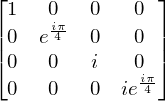

In [10]:
represent(T(0)*S(1),nqubits = 2)

すでに対角化されており、固有値の位相の２進数表示は、0.0,0.001,0.01,0.011であり、これらを誤差なく測定するためには３つの補助量子ビットが必要である。` CGateS ` を用いてこれを制御化した ` cP_2,3,4 `を定義しよう。（2,3,4が３つの補助量子ビットに対応している。）

In [11]:
cP_2 = CGateS(2,T(0))*CGateS(2,S(1))
cP_3 = CGateS(3,T(0))*CGateS(3,S(1))
cP_4 = CGateS(4,T(0))*CGateS(4,S(1))

３つの補助量子ビットを用いて、位相推定アルゴリズムを構成していこう。

In [12]:
PhaEst = H(4)*H(3)*H(2)
PhaEst

制御ユニタリーをそれぞれ、1回、２回、４回と作用させていく。

In [13]:
PhaEst = cP_2*cP_3*cP_3*cP_4*cP_4*cP_4*cP_4*PhaEst

ここから逆量子フーリエ変換を構築する。小数第3位については、補助量子ビット4にH演算を作用させればよい。

In [14]:
PhaEst = H(4)*PhaEst

補助量子ビット3には、まず補助量子ビット4を制御とする制御$R_2=S^{-1}=SZ$演算を作用させる。

In [15]:
PhaEst = CGateS(4,S(3))*PhaEst
PhaEst = CGateS(4,Z(3))*PhaEst

その後にH演算を作用させる。

In [16]:
PhaEst = H(3)*PhaEst

補助量子ビット2には、

- 補助量子ビット3を制御とする制御$R_2 = S^{-1} = SZ$演算
- 補助量子ビット4を制御とする制御$R_3 = TS^{-1} = TSZ$演算
- H演算

の3つを作用させる。

In [17]:
PhaEst = CGateS(3,S(2))*PhaEst
PhaEst = CGateS(3,Z(2))*PhaEst

In [18]:
PhaEst = CGateS(4,T(2))*PhaEst
PhaEst = CGateS(4,S(2))*PhaEst
PhaEst = CGateS(4,Z(2))*PhaEst
PhaEst = H(2)*PhaEst

このように構成した位相推定アルゴリズムを固有ベクトルに作用させてみよう。アルゴリズム自体は非常に複雑だ。

In [19]:
PhaEst

しかし実際、入力に作用させると、

In [20]:
simplify(qapply(PhaEst*Qubit("00011")))

のように設計通り単純な解が得られることが確認できる。実際、補助量子ビット2,3,4にそれぞれ、011が得られたので固有値の位相の２進小数0.011が得られている！他の入力に対しても、

In [21]:
simplify(qapply(PhaEst*Qubit("00000")))

In [22]:
simplify(qapply(PhaEst*Qubit("00010")))

In [23]:
simplify(qapply(PhaEst*Qubit("00001")))

のように、４種類の固有値の位相情報が３つの補助量子ビットに得られた。入力状態が、重ね合わせ状態の場合は、

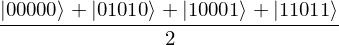

In [24]:
simplify(qapply(PhaEst*H(0)*H(1)*Qubit("00000")))

のように、それぞれの固有ベクトルに対して、固有値の位相が３つの補助量子ビットへと重ね合わせのまま取り出されている。補助量子ビットを測定すると、確率的に、どれか一つの固有ベクトルと固有値が得られる。簡単のためあらかじめ対角化された4×4行列の位相推定を構成したが、もちろん一般のユニタリ$U$に対して動作する。

### 素因数分解と位相推定(難)

位相推定の重要な応用例として、素因数分解アルゴリズムを紹介する。
素因数分解問題は$n$桁の整数$N$が与えられた時に$N$の1ではない約数を
見つける問題であり、従来のコンピュータでは多項式時間で解けるアルゴリズムは
見つかっていない。現在のベストアルゴリズムの計算コストは、
\begin{eqnarray}
O(\exp \left[\frac{64}{9} n (\log n )^2 \right]^{1/3})
\end{eqnarray}
であり、準指数的な計算時間がかかる。
このような素因数分解問題の難しさを利用したRSA暗号などが日常的にも使われている。

P. Shorは1994年に、
量子コンピュータを用いることによって素因数分解問題が桁数$n$に対して多項式時間で解くことができる
ことを示した。これがいわゆるShorの素因数分解アルゴリズムである。

$N$を素因数分解したい整数だとしよう。まず、$N$と互いに素な整数$x$を見つけてくる。
（$x$はユークリッドの互除法で簡単に見つけられる。
適当に$x$を取ってきて、ユークリッドの互除法で$N$と$x$の最大公約数を計算し、
それが1以外の整数であれば$N$の非自明な約数がみつかったことになり(素)因数分解が完了するし、
1しかなければ$x$は$N$と互いに素な整数であることになる。）
このとき、$x$の$N$に関する位数$r$を考えてみる。
位数$r$とは、
\begin{eqnarray}
x^r \equiv 1 \textrm{ (mod $N$)}
\end{eqnarray}
を満たす最小の整数であり、ランダムに$x$を選ぶと高い確率で$r$は偶数になることが知られている。
$r$が偶数であると、上式は
\begin{eqnarray}
(x^{r/2} + 1) (x^{r/2} - 1)  \equiv 0  \textrm{ (mod $N$)}
\end{eqnarray}
のように変形することができる。
これはつまり、$x^{r/2} \pm 1 \equiv 0 \: (\textrm{mod} \: N) $であるか、
$x^{r/2} + 1$と$x^{r/2} - 1$が$N$と非自明な公約数(**$N$の因数**)をもつかのどちらかであることを意味する。
実は、$x$がランダムに選ばれているとき、後者の確率が十分高いことも示すことができる。よって、$x^{r/2} + 1$か$x^{r/2} - 1$と$N$との公約数をユークリッドの互除法で用いることにより、最終的に非自明な$N$の因数が見つかることになる。
これを繰り返していくことによって、$N$をどんどん小さな因数へと分解していくことができ、最終的に素因数分解が達成できる。

　そして、素因数分解の鍵となる位数$r$は、実は入力$y$をmod Nのもとでx倍するという古典計算に対応したユニタリ行列
$$
U_x = \sum _y |yx \: {\rm (mod N)}\rangle \langle y|
$$
の固有値を求めることによって決定することができる。実際、固有状態のラベル$0 \leq s \leq r-1$を用いて，固有ベクトルは 
$$
|u_s\rangle = \frac{1}{\sqrt{r}}
\sum _{k=0}^{r-1} e^ {-2 \pi i (s/r) k }|x^k (\textrm{mod} cu)\rangle.
$$
と書き下すことができ、
$$
U_x |u_s \rangle =  e^{2 \pi i (s/r)} |u_s \rangle
$$
を満たす。つまり固有値の位相推定から$s/r$を求めその分母として$r$を得ることができる（そして、その位数$r$から上記の手順で$N$の素因数分解ができる）。
これがいわゆる、ショアによる素因数分解アルゴリズム（キタエフの位相推定を利用したバージョン）である。

(詳細は Nielsen-Chuang の `5.3 Applicaitons: order-finding and factoring` を参照)

### 第１章のまとめ
ここでは、SymPyの代数処理機能を用いて、量子力学、特にテンソル積の代数を実際に手を動かしながら確認してきた。簡単な系であれば、このように直接状態をシンボルとして書き出すことができるので、計算の確認などに便利である。そして、SymPyを用いながら、もっとも重要な量子アルゴリズムの一つである位相推定アルゴリズムを紹介した。位相推定アルゴリズムは、あるユニタリ行列$U$の固有値を補助量子ビットに取り出すことができる量子アルゴリズムである。素因数分解は、この位相推定アルゴリズムによって、位数という数字を推定することによって解くことができる。また、量子力学においてエネルギーはハミルトニアンと呼ばれる行列の固有値によって与えられる。もっとも安定的な状態のエネルギーはもっとも小さい値の固有値、安定な状態は対応する固有ベクトルで与えられる。ハミルトニアン自体はユニタリー行列ではないものの、行列の指数関数で定義される時間発展に対応するユニタリ行列$e^{-i H t}$に対して位相推定を行うことによって、エネルギーを計算することができる。ほかにも、位相推定による固有値の取り出しを用いて、線形連立方程式の解法([2-2 HHLアルゴリズム])や、その機械学習への応用が研究されている。